####Introduction
Example of using TPUs for CNN to predict windspeed from satellite image of hurricane.  Images are in a Google Bucket in TFRecord format (instead of JPG) to reduce model training time.  TFRecord format allows for more efficient streaming to the model.  

During training, the model checkpoints are saved for the best MSE.  After traning, the final model is saved.   

####**Initial Setup**
Prepare to connect to Google Bucket and Google Drive plus other imports

In [ ]:
from google.colab import drive
from google.colab import auth
auth.authenticate_user()

In [ ]:
import datetime 
import numpy as np
import os

#from functools import partial

import keras as keras

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, \
                                    Flatten, BatchNormalization, Dropout, Input, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint

#import tqdm


####**TPU Setup**
Connect to cluster and set distribution strategy

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.57.227.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.57.227.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


####**Data Files**
Connect to Google Bucket and verify TFRecord file entries look OK. 

In [ ]:
def read_one_whole_rec(data):
  tfrecord_format = (
        {
            "x": tf.io.FixedLenFeature([], tf.string),
            "y": tf.io.FixedLenFeature([], tf.float32)
        }
   )
  
  data = tf.io.parse_example(data, tfrecord_format)
  img = tf.io.decode_raw(data["x"], tf.uint8)
  #expecting this original imgage size 
  img = tf.reshape(img, [366,366,1])
  lab = data["y"]
  return img, lab

# Train set and validation set were decided outside of this notebook.  
# Data was split by storm instead of a random split to keep a storms' images together.  
train_images = tf.data.TFRecordDataset(
    "gs://eye-speed/data/tfrecs/train.tfrecords"
)
ds_train = train_images.map(read_one_whole_rec)

val_images = tf.data.TFRecordDataset(
    "gs://eye-speed/data/tfrecs/val.tfrecords"
)
ds_val = val_images.map(read_one_whole_rec)


Windspeed is 50.0


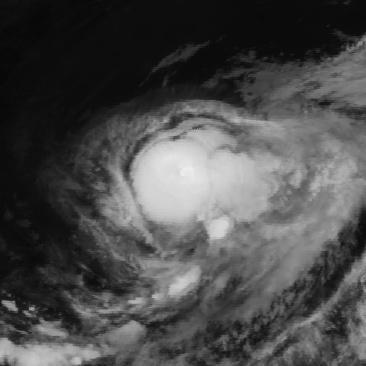

In [ ]:
from PIL import Image 

for example in ds_train.take(1):
  im, lb = example
  print("Windspeed is", str(lb.numpy())) 
  display(Image.fromarray(tf.squeeze(im).numpy())) 


Windspeed is 15.0


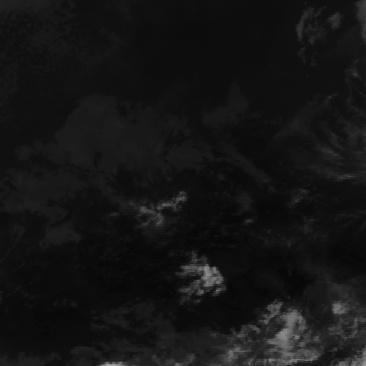

In [ ]:
for example in ds_val.take(1):
  im, lb = example
  print("Windspeed is", str(lb.numpy())) 
  display(Image.fromarray(tf.squeeze(im).numpy())) 


####**Calculations and Batching**
Determine the number of records to send to the model per batch (batch size) and the number of batches for each epoch (steps per epoch)

In [ ]:
#to improve streaming performance
AUTO = tf.data.experimental.AUTOTUNE

TOTAL_RECORDS = ds_train.reduce(np.int64(0), lambda x, _: x + 1)
BATCH_SIZE_PER_REPLICA = 24
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = (TOTAL_RECORDS // GLOBAL_BATCH_SIZE).numpy()
print("Steps per epoch", str(STEPS_PER_EPOCH))

Steps per epoch 295


In [ ]:
# to ensure all batches are the same size, use drop_remainder=True
batched_ds_train = ds_train.batch(GLOBAL_BATCH_SIZE, drop_remainder=True).prefetch(AUTO)
print(batched_ds_train) 

batched_ds_val = ds_val.batch(GLOBAL_BATCH_SIZE, drop_remainder=True).prefetch(AUTO)
print(batched_ds_val)

<PrefetchDataset shapes: ((192, 366, 366, 1), (192,)), types: (tf.uint8, tf.float32)>
<PrefetchDataset shapes: ((192, 366, 366, 1), (192,)), types: (tf.uint8, tf.float32)>


####Model
Create model, associate it with the TPU strategy, then fit.  

In [ ]:
IMG_SIZE = 366
EPOCHS = 100

def create_compile_model_with_bn_dropout_366():
  model = Sequential(
      [
        #seeing OK performance with fullsize images,
        #but preprocessing is an option if needed to make training faster. 
        #preprocessing.Resizing(IMG_SIZE, IMG_SIZE, interpolation="nearest"),
        preprocessing.Rescaling(1./255)
      ]
  )
  model.add(Conv2D(32, (7,7), padding='same', activation='selu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', activation='selu'))
  model.add(Flatten())
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Dense(32, activation='selu'))
  model.add(Dense(1, activation='linear'))

  model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape']) 
  return model

In [ ]:
#associate with TPU strategy
with strategy.scope():
  model = create_compile_model_with_bn_dropout_366()

#setup to save the best model because the last is not necessarily the best. 
d = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
checkpoint_filename = '/content/drive/MyDrive/TeamHurricane/models/best-' + d +'.h5'
checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_mse', verbose=1, save_best_only=True, mode='min') 

#extra logging to know when fitting starts 
print(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d %I:%M:%S %p"))

history = model.fit(batched_ds_train.repeat(), epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, verbose=1, \
                    validation_data=batched_ds_val, callbacks=[checkpoint])

final_filename = '/content/drive/MyDrive/TeamHurricane/models/final-' + d + '.h5'
model.save(final_filename)
print("just saved model" )

2021-02-19 08:07:49 PM
Epoch 1/100
295/295 [==============================] - 144s 434ms/step - loss: 965.9577 - mse: 965.9577 - mae: 23.0601 - mape: 49.1337 - val_loss: 466.4637 - val_mse: 466.4637 - val_mae: 17.5974 - val_mape: 43.7568

Epoch 00001: val_mse improved from inf to 466.46371, saving model to /content/drive/MyDrive/TeamHurricane/models/best-2021-02-19 20:07:49.h5
Epoch 2/100
295/295 [==============================] - 90s 305ms/step - loss: 184.4748 - mse: 184.4748 - mae: 10.3451 - mape: 23.1781 - val_loss: 145.6429 - val_mse: 145.6429 - val_mae: 9.1601 - val_mape: 21.1889

Epoch 00002: val_mse improved from 466.46371 to 145.64290, saving model to /content/drive/MyDrive/TeamHurricane/models/best-2021-02-19 20:07:49.h5
Epoch 3/100
295/295 [==============================] - 90s 304ms/step - loss: 142.7137 - mse: 142.7137 - mae: 9.0990 - mape: 20.4291 - val_loss: 128.2822 - val_mse: 128.2822 - val_mae: 8.5285 - val_mape: 20.5153

Epoch 00003: val_mse improved from 145.64290 t

In [ ]:
model.save(final_filename)
print("just saved model" )

just saved model
